# How do Director's Impact Public Opinion? -Will Herzog 

#### Import libraries and necessary DataFrames to get us started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
imdb_df4 = pd.read_csv('Data/imdb.title.crew.csv') #movie id | directors id | ...
imdb_df6 = pd.read_csv('Data/imdb.title.ratings.csv') #movie id | Average rating | number of votes
name_df = pd.read_csv('Data/imdb.name.basics.csv') #director id | Name | ...

Merge DataFrame imdb_df4  With DataFrame imdb_df6

Movie ID | Directors ID --onto-- Movie ID | Average Rating | Number of Votes

The cell below completes a right-merge of imdb_df4 onto imdb_df6 across the shared index 'tconst'. This maintains the director's index and removes the extraneous values from imdb_df6 that don't match up with the director index.

In [3]:
imdb_df10 = imdb_df6.merge(imdb_df4, left_on='tconst', right_on = 'tconst', how = 'right')
print('This is imdb_df10 info:')
imdb_df10.info()
print('This is imdb_df4 info:')
imdb_df4.info()
print('This is imdb_df6 info:')
imdb_df6.info()

This is imdb_df10 info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146144 entries, 0 to 146143
Data columns (total 5 columns):
tconst           146144 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null float64
directors        140417 non-null object
writers          110261 non-null object
dtypes: float64(2), object(3)
memory usage: 6.7+ MB
This is imdb_df4 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
tconst       146144 non-null object
directors    140417 non-null object
writers      110261 non-null object
dtypes: object(3)
memory usage: 3.3+ MB
This is imdb_df6 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
tconst           73856 non-null object
averagerating    73856 non-null float64
numvotes         73856 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In this cell I am removing the NaN values that would otherwise disrupt the analysis. We also see from above, that the dataframes are not the same size. This will result in a significant number of NaNs. While I have 140,000+ directors in imdb_df4, I only have 73,856 reviews/rankings. Fabricating values to fill the NaN's is a possibility. However, fabricating a summary statistic to represent the missing director's reviews and votes would be inappropriate. This is attributed to the small sample size of each director. Summary statistics would be highly volatile, and would cause more harm than good.

In [4]:
imdb_df10.dropna(subset = ['averagerating'], inplace=True)
imdb_df10.dropna(subset = ['numvotes'], inplace = True)  
imdb_df10.dropna(subset = ['directors'], inplace = True)
imdb_df10.drop(['writers'],inplace = True, axis = 1)

The input below creates a new column called 'pos_reaction'. This is done to better analyse the impact of the number of votes and the review rating. 

In [5]:
imdb_df10['pos_reaction'] = imdb_df10['averagerating'] * imdb_df10['numvotes']

Below, we are grouping by the director, and summing to convert the dataframe groupby type to a dataframe type. The unique directors are also formated as an index to be referred to later. 

In [42]:
pos_reaction = pd.DataFrame(imdb_df10.groupby('directors').sum())['pos_reaction']
pos_reaction.index;

Here the code is counting the unique itterations of the directors, as well as the number of counts that it shows up.
We initialize an empty dictionary, to place key, value pairs of the director index and the average positive reaction that gets synthisized in the for loop.

In [43]:
directors, counts = np.unique(imdb_df10['directors'], return_counts=True)

dir_pos = {}
for director, count in zip(directors, counts):
    dir_pos[director] = ((pos_reaction.loc[director])/count) #gets the total pos_reaction / count of films made 

Below, is the result of the dictionary, now converted over to a dataframe type object, titled: top_10_directors

In [44]:
top_10_directors = pd.DataFrame(list(dir_pos.items()), columns=['directors', 'avg_positive_reaction'])
top_10_directors.head()

,directors,avg_positive_reaction
0,nm0000080,31167.300
1,nm0000095,759245.975
2,nm0000108,726711.650
3,nm0000110,1529239.040
4,nm0000118,214407.200


Since we're only concerned about the top 10 directors, we sort the table based on the average positive reaction. Then reassigning the working data frame as the first 10 values. In anticipation of our next process, we reset the index so we may access it more easily in the following steps.

In [26]:
top_10_directors = top_10_directors.sort_values('avg_positive_reaction', ascending = False).head(10).reset_index()

#### The purpose of the next few lines is to seperate the directors column into 2 columns, to account for multiple directors
##### The reason being, when multiple directors contribute to the film, the database simply adds the additional director into the column. By spliting the column at a ',' we are able to refrence each director's specific ID to investigate the person's name, and any additional information we might need.

Below, we define a function that trys to split the column at a ',' but if it throws an error, it will return an empty string to the new column, instead of crashing the translation.

In [27]:
def split_column(director_str):
    mk_split = director_str.split(',')
    try:
        return mk_split[1]
    except:
        return ''

Here we approach splitting the column in 2 different manners:

The first line will split the first director off at the commam, and insert it into a new column labeled 'director1'

The second line applies the function and will circumvent any error that might be triggered by indexes not matching.

In [28]:
top_10_directors['director1'] = top_10_directors['directors'].apply(lambda x: x.split(',')[0])
top_10_directors['director2'] = top_10_directors['directors'].apply(split_column)
top_10_directors

,index,directors,avg_positive_reaction,director1,director2
0,7622,nm0634240,1.067972e+07,nm0634240,
1,18805,nm1783265,6.566776e+06,nm1783265,
2,438,nm0004306,6.325371e+06,nm0004306,
3,10404,nm0881279,5.662409e+06,nm0881279,
4,8989,"nm0761498,nm0213450",4.951522e+06,nm0761498,nm0213450
5,10853,nm0923736,4.852477e+06,nm0923736,
6,8862,"nm0751577,nm0751648",4.833245e+06,nm0751577,nm0751648
7,62,nm0000399,4.523357e+06,nm0000399,
8,3075,"nm0230032,nm0215455",4.396684e+06,nm0230032,nm0215455
9,608,nm0009190,3.984295e+06,nm0009190,


#### The objective of this next section is to merge name_df onto top_10_directors. 
##### This will require 2 merges due to the fact that we are finding the corresponding director for 2 columns.

Here we are opening a new csv file that combines the director refrence number and the paired name

In [29]:
name_df = pd.read_csv('Data/imdb.name.basics.csv')
name_df['name_directors'] = name_df['primary_name']

In [30]:
name_df.head(1)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,name_directors
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",Mary Ellen Bauder


In [31]:
top_10_directors.head(1)

,index,directors,avg_positive_reaction,director1,director2
0,7622,nm0634240,10679723.7,nm0634240,


This merge is being excecuted on top_10_directors, maintaining the index on the left-hand of the function.
The shared column thats being refrenced is "director1" from top_10_directors and "nconst" from name_df.

In [32]:
top_10_directors_names = top_10_directors.merge(name_df, left_on = 'director1', right_on = 'nconst', how = 'left')
top_10_directors_names.head(1)


,index,directors,avg_positive_reaction,director1,director2,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,name_directors
0,7622,nm0634240,10679723.7,nm0634240,,nm0634240,Christopher Nolan,1970.0,NaN,"writer,producer,director","tt0482571,tt1375666,tt5013056,tt0154506",Christopher Nolan


A similar process is done to link the second director to the name_df.

This time we refrence 'director2' as the left-hand pair to be linked with 'nconst' from the name_df.

In [33]:
top_10_directors_names2 = top_10_directors_names.merge(name_df, left_on = 'director2', right_on = 'nconst', how = 'left')
top_10_directors_names2.head(1)

,index,directors,avg_positive_reaction,director1,director2,nconst_x,primary_name_x,birth_year_x,death_year_x,primary_profession_x,known_for_titles_x,name_directors_x,nconst_y,primary_name_y,birth_year_y,death_year_y,primary_profession_y,known_for_titles_y,name_directors_y
0,7622,nm0634240,10679723.7,nm0634240,,nm0634240,Christopher Nolan,1970.0,NaN,"writer,producer,director","tt0482571,tt1375666,tt5013056,tt0154506",Christopher Nolan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above dataframe is very messy as a result of the merge. 

In order to expedite the process, below, I created an empty dataframe to be populated by the data that is deemed usefull.

The final column 'Director(s)' will be refrenced in the graphing section that follows. It is simply a summation of 'Director1' and 'Director2' columns. In the event of having only one director, we replace the NaN value that is created as a result of the summation, with the value from 'Director1'.

In [34]:
final_df = pd.DataFrame()
final_df['Director_ID'] = top_10_directors_names2['directors']
final_df['Avg_Positive_Reaction'] = top_10_directors_names2['avg_positive_reaction']
final_df['Director_1'] = top_10_directors_names2['primary_name_x']
final_df['Director_2'] = top_10_directors_names2['primary_name_y']
#final_df['Director(s)'] = pd.Series()
final_df['Director(s)'] = final_df['Director_1'] + ', ' + final_df['Director_2']
final_df['Director(s)'].fillna(final_df['Director_1'], inplace = True)

In [35]:
final_df 

,Director_ID,Avg_Positive_Reaction,Director_1,Director_2,Director(s)
0,nm0634240,1.067972e+07,Christopher Nolan,NaN,Christopher Nolan
1,nm1783265,6.566776e+06,Tim Miller,NaN,Tim Miller
2,nm0004306,6.325371e+06,George Miller,NaN,George Miller
3,nm0881279,5.662409e+06,Lee Unkrich,NaN,Lee Unkrich
4,"nm0761498,nm0213450",4.951522e+06,Chris Sanders,Dean DeBlois,"Chris Sanders, Dean DeBlois"
5,nm0923736,4.852477e+06,Joss Whedon,NaN,Joss Whedon
6,"nm0751577,nm0751648",4.833245e+06,Anthony Russo,Joe Russo,"Anthony Russo, Joe Russo"
7,nm0000399,4.523357e+06,David Fincher,NaN,David Fincher
8,"nm0230032,nm0215455",4.396684e+06,Pete Docter,Ronnie Del Carmen,"Pete Docter, Ronnie Del Carmen"
9,nm0009190,3.984295e+06,J.J. Abrams,NaN,J.J. Abrams


In [36]:
imdb_df10.loc[imdb_df10['directors'] == 'nm0634240']

,tconst,averagerating,numvotes,directors,pos_reaction
8738,tt1345836,8.4,1387769.0,nm0634240,11657259.6
24920,tt0816692,8.6,1299334.0,nm0634240,11174272.4
49039,tt5013056,7.9,466580.0,nm0634240,3685982.0
63498,tt1375666,8.8,1841066.0,nm0634240,16201380.8


#### This bar plot illustrates that when compared to his peers in the group Christorpher Nolan has a significantly higher positive reaction on those viewing his films.

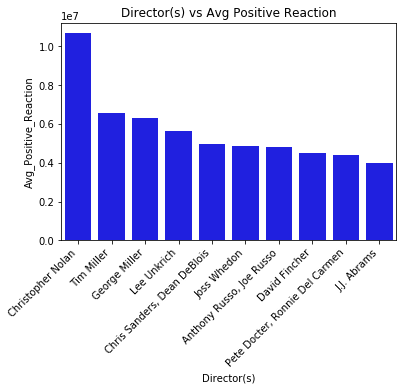

In [55]:
directors = sns.barplot(x= final_df['Director(s)'], y= final_df['Avg_Positive_Reaction'], color= 'blue')
directors.set_xticklabels(directors.get_xticklabels(), rotation=45, ha='right');
plt.title('Director(s) vs Avg Positive Reaction');

# How do Sequels Affect Cashflow? -Will Herzog


#### Import the necesarry libraries 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Import dataframe

In [57]:
tn_df10 = pd.read_csv('Data/tn.movie_budgets.csv')

Below, we are modifying the columns in tn_df10 to drop the non-numerical values that show up, ',' and '$' and convert it to an integer.

This will allow us to further manipulate the dataframe to answer our question.

In [59]:
tn_df10['production_budget'] = tn_df10['production_budget'].astype(str)
tn_df10['production_budget'] = tn_df10['production_budget'].str.replace(",", "", regex = True)
tn_df10['production_budget'] = tn_df10['production_budget'].str.replace("$", "", regex = True)
tn_df10['production_budget'] = tn_df10['production_budget'].astype(int)

tn_df10['domestic_gross'] = tn_df10['domestic_gross'].astype(str)
tn_df10['domestic_gross'] = tn_df10['domestic_gross'].str.replace(",", "", regex = True)
tn_df10['domestic_gross'] = tn_df10['domestic_gross'].str.replace("$", "", regex = True)
tn_df10['domestic_gross'] = tn_df10['domestic_gross'].astype(int)

tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].astype(str)
tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].str.replace(",", "", regex = True)
tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].str.replace("$", "", regex = True)
tn_df10['worldwide_gross'] = tn_df10['worldwide_gross'].astype(int)

In the cell below, we are creating a new column that subtracts the production budget column from the worldwide_gross column.

This column with give us the profit of the film, which is a good indication of how the film performed vs its peers.

In [72]:
tn_df10['profit'] = tn_df10['worldwide_gross'] - tn_df10['production_budget']

Below is shoing the resulting table with the new column profit added at the end.

In [73]:
tn_df10.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425,663420425
8,9,"Nov 17, 2017",Justice League,300000000,229024295,655945209,355945209
9,10,"Nov 6, 2015",Spectre,300000000,200074175,879620923,579620923


From the table above, we are looking for similar words that would tie series together into groups Idealy there would be some sort of indetifer we could group by and automate this string search.

Below, to circumvent this gap in the data, we select a grouping of words that would be contained in sequel series, and insert them into a new dataframe that is specific to that sequel group.

From each sequel group, we take the sum to get the total profit for the sequel group.

In [74]:
pirates = tn_df10[tn_df10['movie'].str.contains('Pirates of the')]
pirates_profit = pirates['profit'].sum()

avengers = tn_df10[tn_df10['movie'].str.contains('Avengers')]
avengers_profit = avengers['profit'].sum()

star_wars = tn_df10[tn_df10['movie'].str.contains('Star Wars')]
star_wars_profit = star_wars['profit'].sum()

transformers = tn_df10[tn_df10['movie'].str.contains('Transformers')]
transformers_profit = transformers['profit'].sum()

x_men = tn_df10[tn_df10['movie'].str.contains('X-Men')]
x_men_profit = x_men['profit'].sum()

harry_potters = tn_df10[tn_df10['movie'].str.contains('Harry Potter')]
harry_potters_profit = harry_potters['profit'].sum()

fast_furious = tn_df10[tn_df10['movie'].str.contains('Furious')]
fast_furious_profit = fast_furious['profit'].sum()

jurassics = tn_df10[tn_df10['movie'].str.contains('Jurassic')]
jurassics_profit = jurassics['profit'].sum()

Here we are gouping the values from above as key-value pairs, where the key is the sequel grouping and the value is the total profit the sequel group.
This will help in converting to dataframe for further analysis.

In [75]:
profits = {'Jurassic Park': jurassics_profit, 'Fast and the Furious': fast_furious_profit, 'Harry Potter': harry_potters_profit, 'Pirates of the Carribean': pirates_profit, 'Avengers': avengers_profit, 'Starwars': star_wars_profit, 'Transformers': transformers_profit, 'X Men': x_men_profit}

Converting the dictionary into a dataframe.

In [77]:
sequel_profits = pd.DataFrame(list(profits.items()), columns=['sequel_title', 'total_profit'])

Below, we sort based on total profit.

We reset the index, for ease of refrence later.

We created a new column called "total profit billions" which is total profit devided by a billion. This will make it easier to interprete for the audience.

In [78]:
sequel_profits.sort_values('total_profit', ascending = False, inplace = True)
sequel_profits.reset_index(inplace = True)
sequel_profits['Total_profit_billions'] = (sequel_profits['total_profit'] / 1000000000)

In [79]:
sequel_profits

,index,sequel_title,total_profit,Total_profit_billions
0,5,Starwars,7789186202,7.789186
1,2,Harry Potter,6573694807,6.573695
2,0,Jurassic Park,4361979246,4.361979
3,4,Avengers,4102069476,4.102069
4,1,Fast and the Furious,3622650892,3.622651
5,6,Transformers,3392515250,3.392515
6,3,Pirates of the Carribean,3192895352,3.192895
7,7,X Men,2085643235,2.085643


Lastly, we are plotting the sequel groupings against the total profit billions.

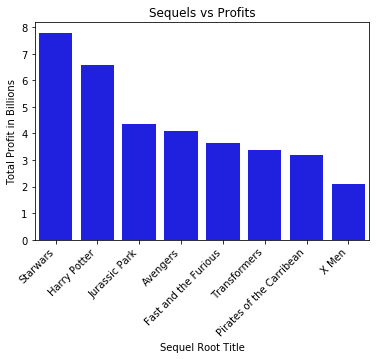

In [81]:
sequels_plt = sns.barplot(x= sequel_profits['sequel_title'], y= sequel_profits['Total_profit_billions'], color= 'blue')
sequels_plt.set_xticklabels(sequels_plt.get_xticklabels(), rotation=45, ha='right');
sequels_plt.set(xlabel = 'Sequel Root Title', ylabel = 'Total Profit in Billions')
plt.title('Sequels vs Profits');

### As a note - Each of these have significant monatary exposure outside of box office in the form of merchandise, theme parks, and spin-off movies. Upon further, crude, investigation, the profit from the entire sequel grouping is a small fraction of the profit attributed to merchandise/marketing. One hypothesis to be evaluated further is how the continuous exposure to movies in a sequel, affects the merchandise sales as compared to stand-alone movies.

# How do Genres Affect Movie Gross?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import python libraries to excute code

EDA: Explore 11 Datasets 

In [2]:
bom_df = pd.read_csv('Data/bom.movie_gross.csv')
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
import pandas as pd
movie_budgetdf = pd.read_csv('Data/tn.movie_budgets.csv')
movie_budgetdf.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


I wanted to get the count of the genres in the DataFrame. I called the Data Frame and indexed the column 'genres', and  used the .value_counts() function to get the count of the genres.

In [4]:
# ratings and reviews
#only want movies from 2009-2019
title_basicsdf = pd.read_csv('Data/imdb.title.basics.csv')

title_basicsdf["genres"].value_counts().head()


Documentary     32185
Drama           21486
Comedy           9177
Horror           4372
Comedy,Drama     3519
Name: genres, dtype: int64

I called this Data Frame becuase I want the domestic_gross and foreign_gross columns.

In [5]:
bom_df = pd.read_csv('Data/bom.movie_gross.csv')
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


I want to use this Data Frame, but it has too many NaN values.
The way I can fix this is by replacing all the NaN with the mean of the box office

In [6]:
movie_infodf = pd.read_csv('Data/rt.movie_info.tsv', encoding='Windows-1254', delimiter = '\t')
movie_infodf['box_office'].mean

<bound method Series.mean of 0              NaN
1          600,000
2              NaN
3              NaN
4              NaN
5              NaN
6       41,032,915
7          224,114
8          134,904
9              NaN
10             NaN
11             NaN
12             NaN
13             NaN
14             NaN
15       1,039,869
16      99,165,609
17             NaN
18      20,518,224
19       1,971,135
20             NaN
21             NaN
22             NaN
23             NaN
24             NaN
25             NaN
26             NaN
27             NaN
28         312,136
29         201,010
           ...    
1530    72,700,000
1531           NaN
1532           NaN
1533           NaN
1534           NaN
1535           NaN
1536       581,813
1537     1,320,005
1538           NaN
1539           NaN
1540           NaN
1541    25,335,935
1542     1,416,189
1543           NaN
1544           NaN
1545        59,371
1546       794,306
1547           NaN
1548           NaN
1549           NaN
15

In [7]:
movie_infodf.groupby(['genre']),['box_office'].sort(reverse = False)

(<pandas.core.groupby.generic.DataFrameGroupBy object at 0x1a163569e8>, None)

I merged 2 Data Frames together using the .join() method. I did this because I wanted to put all the Data I need from the 2 Data Frames and put it into 1 Data Frame

In [8]:
#merge title basic and title rating because they have t constant

left = title_basicsdf
right = movie_budgetdf
favorite_df = left.join(right)
favorite_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",1.0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",2.0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,3.0,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",4.0,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",5.0,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In this cell I am filling the NaN and changing the dtype. I am filling the NaN with the mean value, and changing the dtype from a str to an 

In [9]:

movie_infodf['box_office'] = movie_infodf['box_office'].fillna(8261566).astype(str).str.replace(",", "").astype(int)
movie_infodf.groupby(['genre'])['box_office'].value_counts()
movie_infodf['box_office']


0        8261566
1         600000
2        8261566
3        8261566
4        8261566
5        8261566
6       41032915
7         224114
8         134904
9        8261566
10       8261566
11       8261566
12       8261566
13       8261566
14       8261566
15       1039869
16      99165609
17       8261566
18      20518224
19       1971135
20       8261566
21       8261566
22       8261566
23       8261566
24       8261566
25       8261566
26       8261566
27       8261566
28        312136
29        201010
          ...   
1530    72700000
1531     8261566
1532     8261566
1533     8261566
1534     8261566
1535     8261566
1536      581813
1537     1320005
1538     8261566
1539     8261566
1540     8261566
1541    25335935
1542     1416189
1543     8261566
1544     8261566
1545       59371
1546      794306
1547     8261566
1548     8261566
1549     8261566
1550     8261566
1551     8261566
1552     8261566
1553     8261566
1554     8261566
1555    33886034
1556     8261566
1557     82615

This is the new and improved Data Frame. There were very few Nan Values left, so I just dropped them because they would not make that big of a differnce in the Data. Next I use Seaborn to plot my data in a bar plot

TypeError: '<' not supported between instances of 'float' and 'str'

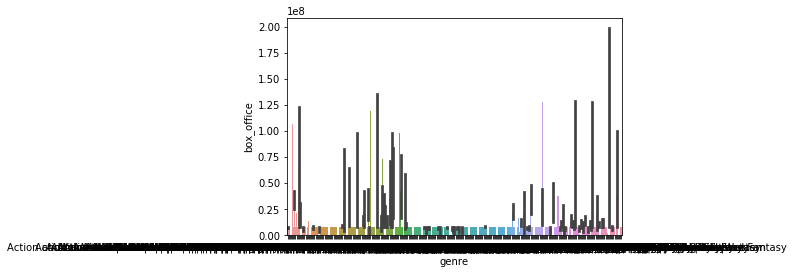

In [10]:
movie_infodf
genre_bodf = pd.DataFrame()
genre_bodf['genre'] = movie_infodf['genre']
genre_bodf['box_office'] = movie_infodf['box_office']
genre_bodf.dropna()
box_officedf = pd.DataFrame()
box_officedf = genre_bodf['box_office'] 
genre_bodf.genre = genre_bodf.genre.astype('category')
sns.barplot(genre_bodf.genre,genre_bodf.box_office)


bin_intervals = [0, 0.25, 0.50, 0.75, 1.0]
bin_labels = ['action','thiller','drama','comedy']
genre_bodf['genre'] = pd.cut(genre_bodf['genre'], bins = bin_intervals, labels = bin_labels)



#df['data'] = pd.DataFrame(x)
#binInterval = [0, 0.6, 0.7, 0.8, 0.9]
#binLabels   = [0, 4, 3, 2, 1]
#df['binned'] = pd.cut(df['data'], bins = binInterval, labels=binLabels)

In this cell I made a new Data Frame that contains the 2 columns I want: Box Office & Genre. This new Data Frame shows the Genre of the Movie and how much money it has generated. There were a few NaN values left, so I dropped them. Then I sorted the genres by how much they made in the box office from most box office revenue to least.

In [23]:
genre_bodf.dropna(inplace=True)


In [24]:
genre_bodf.head(10)

,genre,box_office
0,Action and Adventure|Classics|Drama,8261566
1,Drama|Science Fiction and Fantasy,600000
2,Drama|Musical and Performing Arts,8261566
3,Drama|Mystery and Suspense,8261566
4,Drama|Romance,8261566
5,Drama|Kids and Family,8261566
6,Comedy,41032915
7,Drama,224114
8,Drama,134904
9,Action and Adventure|Mystery and Suspense|Scie...,8261566


I am calling my Data Frame and changing the type to category. Then I am calling the 'genre' collumn to see how many unique values it has using the .unique function. Then I turn my genre column into a list.

In [20]:
genre_bodf.genre = genre_bodf.genre.astype('category')
genre_bodf['genre'].unique()
genres_ = list(genre_bodf['genre'])


After making a list of genres types I made a dictionary that holds the genre as the key and the count as the value.

In [21]:
#list = genres_

#ro_gen = list(genre)
#ro_gen_AA = genre_bodf.loc[genre_bodf['genre']== 'Action and Adventure']

gen_count_dic = {}

# key is the genre
# value is the box office revenue

for genre in genres_:
    gen_count_dic.update({genre:0})

#print(gen_count_dic)
    
    
#genre_bodf2019 = genre_bodf.loc[genre_bodf['genre'] == 'Action and Adventure']


I used a for loop in my dictionary to get the count of how many times a genre come up. I sort the box office values from heighest to lowest using the .sort_values() method. Then I used seaborn to help me visualize my data.

Text(0.5, 1.0, 'Genres With Box Office')

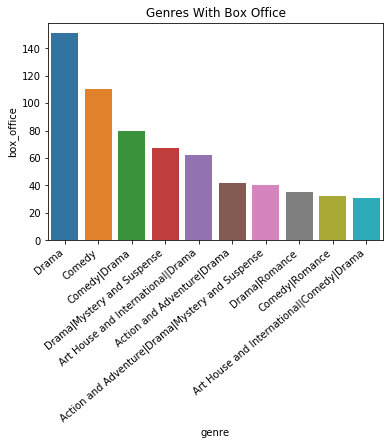

In [22]:
value, counts = np.unique(genres_ ,return_counts = True)
for value, count in zip(value, counts):
    gen_count_dic[value]= count

gen_count_dic

genres_bo2019 = pd.DataFrame(list(gen_count_dic.items()), columns=['genre','box_office'])
genres_bo2019

genres_bo2019 = genres_bo2019.sort_values('box_office', ascending=False).head(10).reset_index()
genres2 = sns.barplot(x= genres_bo2019['genre'],y=genres_bo2019['box_office'])
genres2.set_xticklabels(genres2.get_xticklabels(), rotation=40, ha='right');
plt.title('Genres With Box Office')

# What were the Top 10 Grossing Studios, per year, over the past Decade?

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cleaner
import studio_formulas
%reload_ext autoreload
%autoreload 2

### Preform Exploratory Data Analysis: bom_df dataset 


In the following, steps we explored the bom_df dataset utilize the .shape, .items, .doctype methods 

In [138]:
bom_df = pd.read_csv('data/bom.movie_gross.csv') #import the bom_df dataset
bom_df.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [139]:
bom_df.shape #here we see that our dataframe is 3387 rows by 5 columns

(3387, 5)

In [140]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


The .info() method allows us to see how much cleaning we need to do of our indices. It looks like the foreign_gross may present some issues with missing data. This would be a good column to drop.

In [141]:
bom_df.index

RangeIndex(start=0, stop=3387, step=1)

In [205]:
bom_df.dtypes

title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

### Define our Question: how do you begin to organize by year, studio, and domestic gross?

In [4]:
studio_gross = bom_df[['studio','domestic_gross','year']]
studio_gross.head()

,studio,domestic_gross,year
0,BV,415000000.0,2010
1,BV,334200000.0,2010
2,WB,296000000.0,2010
3,WB,292600000.0,2010
4,P/DW,238700000.0,2010


Above is our new dataframe studio_gross containing the essentail columns needed to answer our question

We can further approach this question with the groupby function. This is a first go, but it appears that the groupby function will be a critical commponent to achieving our answer. The output below breaks out each year 2010 - 2018 and the number of studios, but it's missing the domestic gross


In [5]:
studio_gross.groupby(['year', 'studio', 'domestic_gross']).groups
studio_gross.groupby('year').groups

{2010: Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             318, 319, 320, 321, 322, 323, 324, 325, 326, 327],
            dtype='int64', length=328),
 2011: Int64Index([328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
             ...
             717, 718, 719, 720, 721, 722, 723, 724, 725, 726],
            dtype='int64', length=399),
 2012: Int64Index([ 727,  728,  729,  730,  731,  732,  733,  734,  735,  736,
             ...
             1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126],
            dtype='int64', length=400),
 2013: Int64Index([1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136,
             ...
             1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476],
            dtype='int64', length=350),
 2014: Int64Index([1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486,
             ...
             1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871],
            dtype='int64', len

### continuing to figure out how to organize the data...

this is a step in the right direction, the groupby function was able to group the dataframe by year and studio. 
the .groups method then was able to displays this data 
to improve this data, we would like to add in domestic_gross data

Perhaps we need a list of all of the studios we're working with. This studio list may come in handy in order to preform a future sort

In [6]:
studio_list = bom_df['studio'].unique()

By utilizing the .unique method, the code above gives us a list of studios 

In [7]:
print(studio_list)

['BV' 'WB' 'P/DW' 'Sum.' 'Par.' 'Uni.' 'Fox' 'Wein.' 'Sony' 'FoxS' 'SGem'
 'WB (NL)' 'LGF' 'MBox' 'CL' 'W/Dim.' 'CBS' 'Focus' 'MGM' 'Over.' 'Mira.'
 'IFC' 'CJ' 'NM' 'SPC' 'ParV' 'Gold.' 'JS' 'RAtt.' 'Magn.' 'Free' '3D'
 'UTV' 'Rela.' 'Zeit.' 'Anch.' 'PDA' 'Lorb.' 'App.' 'Drft.' 'Osci.' 'IW'
 'Rog.' nan 'Eros' 'Relbig.' 'Viv.' 'Hann.' 'Strand' 'NGE' 'Scre.' 'Kino'
 'Abr.' 'CZ' 'ATO' 'First' 'GK' 'FInd.' 'NFC' 'TFC' 'Pala.' 'Imag.' 'NAV'
 'Arth.' 'CLS' 'Mont.' 'Olive' 'CGld' 'FOAK' 'IVP' 'Yash' 'ICir' 'FM'
 'Vita.' 'WOW' 'Truly' 'Indic.' 'FD' 'Vari.' 'TriS' 'ORF' 'IM' 'Elev.'
 'Cohen' 'NeoC' 'Jan.' 'MNE' 'Trib.' 'Rocket' 'OMNI/FSR' 'KKM' 'Argo.'
 'SMod' 'Libre' 'FRun' 'WHE' 'P4' 'KC' 'SD' 'AM' 'MPFT' 'Icar.' 'AGF'
 'A23' 'Da.' 'NYer' 'Rialto' 'DF' 'KL' 'ALP' 'LG/S' 'WGUSA' 'MPI' 'RTWC'
 'FIP' 'RF' 'ArcEnt' 'PalUni' 'EpicPics' 'EOne' 'LD' 'AF' 'TFA' 'Myr.'
 'BM&DH' 'SEG' 'PalT' 'Outs' 'OutF' 'BSM' 'WAMCR' 'PM&E' 'A24' 'Cdgm.'
 'Distrib.' 'Imax' 'PH' 'HTR' 'ELS' 'PI' 'E1' 'TVC' 'FEF' 'EXCL

We're moving in the right direction. Below is an even better appraoch at answering our question. We've utilized the groupby., value_counts, and reset_index method in order to count the number of movies a studio produced by year. This is stil missing the domestic gross component. 

In [4]:
bom_df.groupby('year').studio.value_counts().reset_index(name='counts')


,year,studio,counts
0,2010,IFC,22
1,2010,SPC,19
2,2010,WB,19
3,2010,Fox,17
4,2010,Magn.,16
...,...,...,...
737,2018,Swen,1
738,2018,Synergetic,1
739,2018,Trafalgar,1
740,2018,Vita.,1


Here's another version of the groupby function and value counts 

In [231]:
bom_df.groupby('year').studio.value_counts()

year  studio    
2010  IFC           22
      SPC           19
      WB            19
      Fox           17
      Magn.         16
                    ..
2018  Swen           1
      Synergetic     1
      Trafalgar      1
      Vita.          1
      Yash           1
Name: studio, Length: 742, dtype: int64

This is great progress. However, how do we incorporate domestic gross? 

In [9]:
bom_df.groupby(['year','studio'])['domestic_gross']

In [10]:
bom_dfdf = bom_df.groupby(['studio','domestic_gross'])


In [5]:
bom_df2018 = bom_df.loc[bom_df['year'] == 2018 ]
bom_df2018


,title,studio,domestic_gross,foreign_gross,year
3079,Avengers: Infinity War,BV,678800000.0,"1,369.5",2018
3080,Black Panther,BV,700100000.0,646900000,2018
3081,Jurassic World: Fallen Kingdom,Uni.,417700000.0,891800000,2018
3082,Incredibles 2,BV,608600000.0,634200000,2018
3083,Aquaman,WB,335100000.0,812700000,2018
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [250]:
bom_df2018_WB = bom_df2018.loc[bom_df2018['studio'] == 'WB']

In [293]:
bom_df2018_WB['domestic_gross'].sum()

1729100000.0

In [251]:
bom_df2018_WB.head()


,title,studio,domestic_gross,foreign_gross,year
3083,Aquaman,WB,335100000.0,812700000,2018
3088,Fantastic Beasts: The Crimes of Grindelwald,WB,159600000.0,494100000,2018
3090,Ready Player One,WB,137700000.0,445200000,2018
3092,Detective Chinatown 2,WB,2000000.0,542100000,2018
3093,The Meg,WB,145400000.0,384800000,2018


I'm able to make a dataframe that is filtered by year and by a single studio. Now, I would like to iterate this across all studios in 2018 

In [8]:
#List of all studios active in 2018 

bom_df.dropna(subset = ['foreign_gross'], inplace = True)

In [9]:
bom_df2018 = bom_df.loc[bom_df['year'] == 2018]
bom_df2018['studio'].unique()
studios_2018 = bom_df2018['studio'].unique()

In [291]:

#bom_df2018['total_gross'] = bom_df2018['domestic_gross'] + bom_df2018['foreign_gross']

In [10]:
studios_2018 #here is my list of studios for 2018 

array(['BV', 'Uni.', 'WB', 'Fox', 'Sony', 'Par.', 'WGUSA', 'WB (NL)',
       'LGF', 'MGM', 'Studio 8', 'FoxS', 'STX', 'Focus', 'PNT', 'LG/S',
       'A24', 'Annapurna', 'SGem', 'FIP', 'VPD', 'Global Road', 'CL',
       'IFC', 'Affirm', 'Trafalgar', 'SPC', 'ENTMP', 'Amazon', 'BH Tilt',
       'BST', 'Magn.', 'MBox', 'Greenwich', 'CJ', 'GK', 'Spanglish',
       'Distrib.', 'Blue Fox', 'Scre.', 'Yash', 'Aviron', 'Cohen', 'VE',
       'Grindstone', 'Darin Southa', 'FM'], dtype=object)

Below is the best attempt yet at iterating through all of the studios for 2018. It's a bit bulky, especially in the directory portion (I inserted 3 lines of code for the value part of the key:value pair) but it worked!

In [70]:
#Create a list of studios for 2018 

bom_df2018 = bom_df.loc[bom_df['year'] == 2018]
bom_df2018['studio'].unique()
studios_2018 = bom_df2018['studio'].unique()

studios_2018 #list of  studios in 2018 

#Finding an example studio (WB) and what the studio grossed in year 2018:
bom_df2018 = bom_df.loc[bom_df['year'] == 2018 ]
bom_df2018_WB = bom_df2018.loc[bom_df2018['studio'] == 'WB']
bom_df2018_WB['domestic_gross'].sum()


#Now make a function to preform this on every studio in studios_2018 list 
#I would like a dictionary of studio and its gross for 2018 

studios_2018 
studio_gross_dic = {} #this dictionary contains studio and 2018 domestic gross 

#key = studio name
#value = domestic_gross

for studio in studios_2018: 
    
    
    bom_df2018 = bom_df.loc[bom_df['year'] == 2018 ]
    bom_df2018_WB = bom_df2018.loc[bom_df2018['studio'] == studio]
    bom_df2018_WB['domestic_gross'].sum()

    studio_gross_dic.update({studio : bom_df2018_WB['domestic_gross'].sum()
                             
                             })
                             
                            
print(studio_gross_dic)

{'BV': 3045600000.0, 'Uni.': 1789600000.0, 'WB': 1707900000.0, 'Fox': 840300000.0, 'Sony': 956690000.0, 'Par.': 699400000.0, 'WGUSA': 2538000.0, 'WB (NL)': 395500000.0, 'LGF': 202355400.0, 'MGM': 115700000.0, 'Studio 8': 59900000.0, 'FoxS': 66400000.0, 'STX': 261600000.0, 'Focus': 111900000.0, 'PNT': 50300000.0, 'LG/S': 77600000.0, 'A24': 44648000.0, 'Annapurna': 67300000.0, 'SGem': 92300000.0, 'FIP': 9200000.0, 'VPD': 12216000.0, 'Global Road': 34200000.0, 'CL': 70800.0, 'IFC': 9825000.0, 'Affirm': 17600000.0, 'Trafalgar': 4200000.0, 'SPC': 9600000.0, 'ENTMP': 17400000.0, 'Amazon': 15599999.0, 'BH Tilt': 20900000.0, 'BST': 18500000.0, 'Magn.': 1400.0, 'MBox': 258000.0, 'Greenwich': 1600000.0, 'CJ': 94500.0, 'GK': 35800.0, 'Spanglish': 2600000.0, 'Distrib.': 37100.0, 'Blue Fox': 91000.0, 'Scre.': 29500.0, 'Yash': 330000.0, 'Aviron': 1600000.0, 'Cohen': 200000.0, 'VE': 492300.0, 'Grindstone': 10000.0, 'Darin Southa': 93200.0, 'FM': 43200.0}


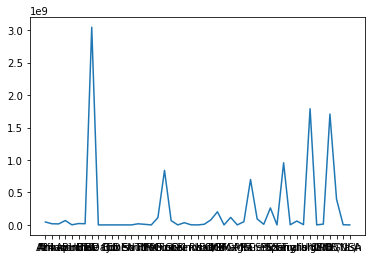

In [12]:
import matplotlib.pylab as plt

lists = sorted(studio_gross_dic.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [18]:
studio_gross = pd.DataFrame(list(studio_gross_dic.items()), columns=['studio','domestic_gross'])
top_10 = studio_gross.sort_values(by ='domestic_gross', ascending=False).head(10)

Text(0.5, 1.0, 'Top 10 Domestic Grossing Studios 2018')

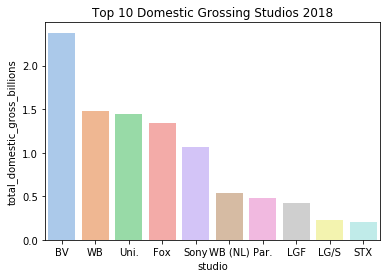

In [64]:
top_10['total_domestic_gross_billions'] = (top_10['domestic_gross']/1000000000)

sns.barplot(x="studio", y="total_domestic_gross_billions", palette= 'pastel', color= 'blue', data=top_10)
plt.title('Top 10 Domestic Grossing Studios 2018')

Now, do the same for 2016

In [71]:

bom_df2017 = bom_df.loc[bom_df['year'] == 2017]
bom_df2017['studio'].unique()
studios_2017 = bom_df2017['studio'].unique()

studios_2017 #list of  studios in 2017 

#Finding an example studio (WB) and what the studio grossed in year 2018:
bom_df2017 = bom_df.loc[bom_df['year'] == 2017 ]
bom_df2017_WB = bom_df2017.loc[bom_df2017['studio'] == 'WB']
bom_df2017_WB['domestic_gross'].sum()


#Now make a function to preform this on every studio in studios_2018 list 
#I would like a dictionary of studio and its gross for 2018 

studios_2017 
studio_gross_dic2017 = {} #this dictionary contains studio and 2018 domestic gross 

#key = studio name
#value = domestic_gross

for studio in studios_2017: 
    
    
    bom_df2017 = bom_df.loc[bom_df['year'] == 2017 ]
    bom_df2017_WB = bom_df2017.loc[bom_df2017['studio'] == studio]
    bom_df2017_WB['domestic_gross'].sum()

    studio_gross_dic2017.update({studio : bom_df2017_WB['domestic_gross'].sum()
                             
                             })
                             
                            
print(studio_gross_dic2017)


{'BV': 2378200000.0, 'Uni.': 1443500000.0, 'Sony': 1062636000.0, 'HC': 2700000.0, 'WB': 1479400000.0, 'WB (NL)': 532400000.0, 'Fox': 1345000000.0, 'Par.': 484699999.0, 'FUN': 5424000.0, 'SGem': 57200000.0, 'LGF': 422465000.0, 'WGUSA': 2081000.0, 'GrtIndia': 20200000.0, 'TriS': 135300000.0, 'STX': 206800000.0, 'FoxS': 154200000.0, 'LG/S': 224900000.0, 'CL': 865000.0, 'Focus': 179900000.0, nan: 0.0, 'Wein.': 44556000.0, 'Yash': 5600000.0, 'A24': 84100000.0, 'ORF': 59699999.0, 'PNT': 32100000.0, 'CJ': 1576000.0, 'Neon': 30000000.0, 'BST': 36400000.0, 'Good Deed': 6700000.0, 'SPC': 19791000.0, 'ParC': 5900.0, 'FIP': 6334000.0, 'Elev.': 1500000.0, 'PFR': 14700000.0, 'Amazon': 1400000.0, 'BBC': 81300.0, 'FR': 211000.0, 'RAtt.': 14824000.0, 'IFC': 1275700.0, 'W/Dim.': 700.0, 'BG': 6223000.0, 'Affirm': 5800000.0, 'Distrib.': 1000000.0, 'Annapurna': 2100000.0, 'FCW': 515000.0, 'Imax': 1500000.0, 'Magn.': 528000.0, 'MOM': 14800.0, 'Vita.': 360000.0}


In [69]:
studio_gross_2017 = pd.DataFrame(list(studio_gross_dic2017.items()), columns=['studio','domestic_gross'])
top_10_2017 = studio_gross_2017.sort_values(by ='domestic_gross', ascending=False).head(10)

Text(0.5, 1.0, 'Top 10 Domestic Grossing Studios 2017')

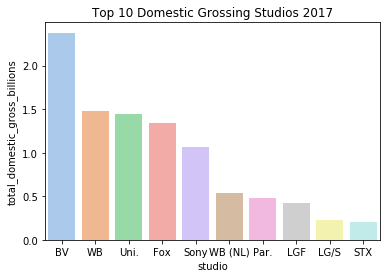

In [68]:

top_10_2017['total_domestic_gross_billions'] = (top_10_2017['domestic_gross']/1000000000)

sns.barplot(x="studio", y="total_domestic_gross_billions", palette= 'pastel', color= 'blue', data=top_10_2017)
plt.title('Top 10 Domestic Grossing Studios 2017')

In [154]:
df = bom_df

Below was some miscellaneous code accessing movie production 

# What were the most active studios in the past 5 years in terms of movie production?

How many active studios in 2018 

In [66]:
df_studios = bom_df.loc[bom_df['year'] == 2018]
len(bom_df2018['studio'].unique())

47

How many active studios in 2017

In [67]:
bom_df2017 = bom_df.loc[bom_df['year'] == 2017]
len(bom_df2017['studio'].unique())

49

How many active studios in 2016

In [129]:
bom_df2016 = bom_df.loc[bom_df['year'] == 2016]
len(bom_df2016['studio'].unique())

92

How many active studios in 2015


In [133]:
bom_df2015 = bom_df.loc[bom_df['year'] == 2015]
len(bom_df2015['studio'].unique())

94

How many active studios in 2014


In [136]:
bom_df2014 = bom_df.loc[bom_df['year'] == 2014]
len(bom_df2014['studio'].unique())

81

In [ ]:
studio_df = pd.DataFrame(bom_df2018.groupby('studio').sum())['']